In [78]:
%load_ext autoreload
%autoreload 2

import os
import numpy as pd
import pandas as pd
import cv2
import pydicom
import scipy

from sklearn.model_selection import train_test_split, StratifiedKFold
from matplotlib import pyplot as plt
from utils.mask_functions import *
from glob import glob
from PIL import Image
from keras_tqdm import TQDMNotebookCallback

import tensorflow as tf
import keras
from keras.applications.resnet50 import ResNet50
from keras.utils import Sequence
from keras.preprocessing.image import load_img
from keras.models import Model, model_from_json
from keras.layers import Input, LeakyReLU, core, Dropout, BatchNormalization, Concatenate, Dense, Flatten, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Parse Data - Create Annotations

In [2]:
rles_df = pd.read_csv('./siim/train-rle.csv')
rles_df.columns = ['ImageId', 'EncodedPixels']
rles_df['Pneumothorax'] = 0
rles_df['NotPneumothorax'] = 0
rles_df['FilePath'] = ''
rles_df.head()

,ImageId,EncodedPixels,Pneumothorax,NotPneumothorax,FilePath
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1,0,0,
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1,0,0,
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...,0,0,
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...,0,0,
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...,0,0,


In [3]:
for n in range(len(rles_df)):
    if '-1' not in rles_df.loc[n, 'EncodedPixels']:
        rles_df.loc[n, 'Pneumothorax'] = 1
    else:
        rles_df.loc[n, 'NotPneumothorax'] = 1
rles_df.head()

,ImageId,EncodedPixels,Pneumothorax,NotPneumothorax,FilePath
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1,0,1,
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1,0,1,
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...,1,0,
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...,1,0,
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...,1,0,


In [4]:
# Add file path to dataframe
train_fps = glob('./siim/dicom-images-train/*/*/*.dcm')
for fp in train_fps:
    dicom_data = pydicom.dcmread(fp)
    rles_df.loc[rles_df.ImageId == dicom_data.SOPInstanceUID, 'FilePath'] = fp

In [5]:
rles_df.head()

,ImageId,EncodedPixels,Pneumothorax,NotPneumothorax,FilePath
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1,0,1,./siim/dicom-images-train\1.2.276.0.7230010.3....
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1,0,1,./siim/dicom-images-train\1.2.276.0.7230010.3....
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...,1,0,./siim/dicom-images-train\1.2.276.0.7230010.3....
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...,1,0,./siim/dicom-images-train\1.2.276.0.7230010.3....
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...,1,0,./siim/dicom-images-train\1.2.276.0.7230010.3....


### Split and Balance the Data

In [6]:
# Imbalance between Pos and Neg classifications:
len(rles_df[rles_df.Pneumothorax == 1]), len(rles_df[rles_df.Pneumothorax == 0])

(3286, 8296)

In [7]:
train_df, val_df = train_test_split(rles_df, stratify=rles_df.Pneumothorax, test_size=0.2, random_state=88)

In [8]:
#len(train_df[train_df.Pneumothorax == 1]), len(val_df[val_df.Pneumothorax == 1])

In [9]:
#zzz = np.empty((5, 1), dtype=np.float32)
#zzz = train_df[0:5].Pneumothorax.values
#print(zzz)
#zzz = train_df[0:10].Pneumothorax.values
#print(train_df[0:10].Pneumothorax.values)
#train_df
#indexes = np.arange(len(self.data_frame))
idx = np.arange(len(train_df))
train_idx = idx[0:5]
print(train_idx)
print(train_df.iloc[train_idx].FilePath)
#train_df[train_idx].FilePath

[0 1 2 3 4]
5773     ./siim/dicom-images-train\1.2.276.0.7230010.3....
6452     ./siim/dicom-images-train\1.2.276.0.7230010.3....
5625     ./siim/dicom-images-train\1.2.276.0.7230010.3....
10527    ./siim/dicom-images-train\1.2.276.0.7230010.3....
7706     ./siim/dicom-images-train\1.2.276.0.7230010.3....
Name: FilePath, dtype: object


In [34]:
#train_df[0:5].FilePath
#zzz = np.array(train_df.iloc[0:5][Pneumothorax, NotPneumothorax].values)
#zzz.shape
#zzz[0]
zzz = train_df.iloc[0:5][['Pneumothorax', 'NotPneumothorax']]
zzz = np.array(zzz)
zzz.shape
zzz[0]

array([0, 1], dtype=int64)

img_height = 1024
img_width = 1024
batch_size = 16

In [35]:
img_height = 512
img_width = 512
n_channels = 1
batch_size = 16

In [36]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data_frame,
                 batch_size=16,
                 augmentations=None,
                 img_height=1024,
                 img_width=1024,
                 n_channels=1,
                 shuffle=True):
        self.data_frame = data_frame
        self.batch_size = batch_size
        self.augment = augmentations
        self.img_height = img_height
        self.img_width = img_width
        self.n_channels = n_channels
        self.shuffle = shuffle
        #self.indexes = np.arange(len(self.data_frame))
        self.on_epoch_end()
        
    def __len__(self):
        'Batches per epoch'
        return int(np.ceil(len(self.data_frame) / self.batch_size))
    
    def on_epoch_end(self):
        'Update indexes when epoch ends'
        self.indexes = np.arange(len(self.data_frame))
        if self.shuffle == True:
            #self.indexes = np.arange(len(self.data_frame))
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        'Get one batch'
        batch_indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.data_frame))]
        
        fps = self.data_frame.iloc[batch_indexes].FilePath
        
        X = self.data_generation(fps)
        #Y = np.float32(self.data_frame.iloc[batch_indexes].Pneumothorax.values)
        Y = self.data_frame.iloc[batch_indexes][['Pneumothorax', 'NotPneumothorax']]
        
        if self.augment is None:
            return np.array(X)/255, np.array(Y)
        else:
            X_aug, Y_aug = [], []
            for image, mask in zip(X, Y):
                augmented = self.augment(image=image, mask=mask)
                X_aug.append(augmented['image'])
                Y_aug.append(augmented['mask'])
            return np.array(X_aug)/255, np.array(Y_aug)
        
    def data_generation(self, fps):
        X = np.empty((len(fps), self.img_height, self.img_width, self.n_channels))
        #Y = np.empty((len(fps), 1), dtype=np.float32)

        for i, fp in enumerate(fps):
            dcm = pydicom.dcmread(fp)
            X[i] = np.expand_dims(cv2.resize(dcm.pixel_array, (self.img_height, self.img_width)), axis=2)
        
        return np.uint8(X)

In [37]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    OneOf([
        RandomContrast(),
        RandomGamma(),
        RandomBrightness(),
         ], p=0.3),
    OneOf([
        ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(),
        OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    RandomSizedCrop(min_max_height=(176, 256), height=img_height, width=img_width,p=0.25),
    ToFloat(max_value=1)
],p=1)


AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=1)
],p=1)

### Train with Masks

In [38]:
def plot_pixel_array(data, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(data, cmap=plt.cm.bone)
    plt.show()
    
def plot_pixel_array_overlay(data, label, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(data, cmap=plt.cm.bone)
    plt.imshow(label, alpha=.3)
    plt.show()

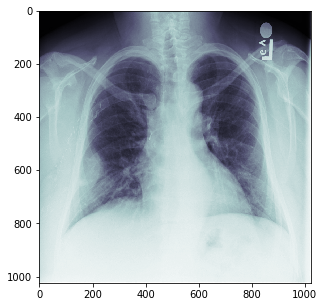

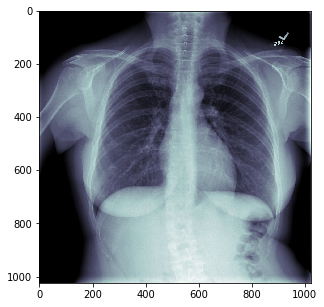

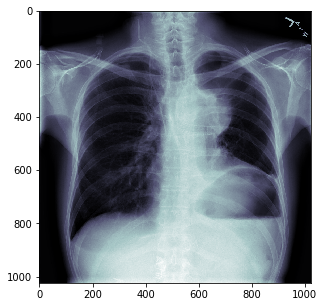

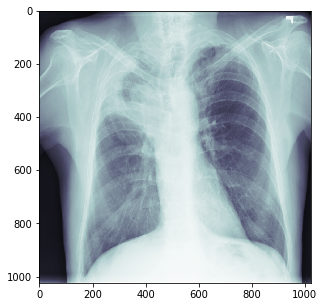

In [39]:
a = DataGenerator(data_frame=train_df, batch_size=4, shuffle=False)
images, masks = a.__getitem__(0)
for image in images.squeeze():
    plot_pixel_array(image, (5, 5))

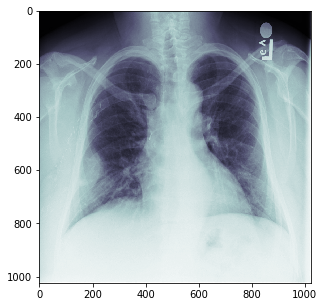

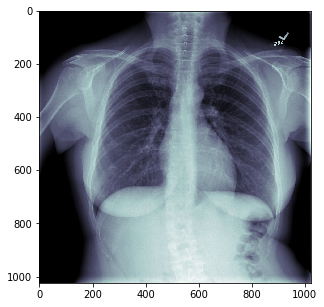

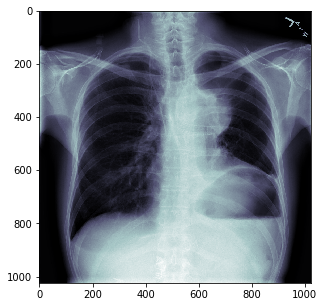

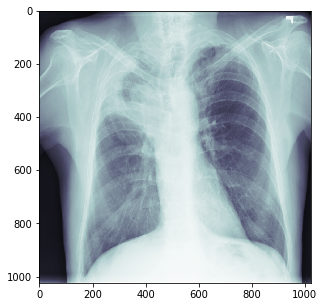

In [40]:
# After augmentations
b = DataGenerator(data_frame=train_df, batch_size=4, augmentations=AUGMENTATIONS_TRAIN, shuffle=False)
images, masks = a.__getitem__(0)
for image in images.squeeze():
    plot_pixel_array(image, (5, 5))

### Balance Data

### Data Loader with Augmentations

### Train on Pretrained ResNet50

In [73]:
def get_resnet50():
    inputs = Input(shape=(img_height, img_width, n_channels))
    conc = Concatenate()([inputs, inputs, inputs])
    
    base = ResNet50(include_top=False, weights='imagenet', input_tensor = conc, classes=2)
    
    for layer in base.layers:
        layer.trainable = True
    
    outputs = GlobalAveragePooling2D()(base.output)
    outputs = Dense(2, activation='softmax')(outputs)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [74]:
K.clear_session()
model = get_resnet50()
model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 512, 512, 3)  0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           concatenate_1[0][0]              
__________________________________________________________________________________________________
conv1 (Con

__________________________________________________________________________________________________
add_3 (Add)                     (None, 128, 128, 256 0           bn2c_branch2c[0][0]              
                                                                 activation_7[0][0]               
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 128, 128, 256 0           add_3[0][0]                      
__________________________________________________________________________________________________
res3a_branch2a (Conv2D)         (None, 64, 64, 128)  32896       activation_10[0][0]              
__________________________________________________________________________________________________
bn3a_branch2a (BatchNormalizati (None, 64, 64, 128)  512         res3a_branch2a[0][0]             
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_21 (Activation)      (None, 64, 64, 128)  0           bn3d_branch2b[0][0]              
__________________________________________________________________________________________________
res3d_branch2c (Conv2D)         (None, 64, 64, 512)  66048       activation_21[0][0]              
__________________________________________________________________________________________________
bn3d_branch2c (BatchNormalizati (None, 64, 64, 512)  2048        res3d_branch2c[0][0]             
__________________________________________________________________________________________________
add_7 (Add)                     (None, 64, 64, 512)  0           bn3d_branch2c[0][0]              
                                                                 activation_19[0][0]              
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
activation_32 (Activation)      (None, 32, 32, 256)  0           bn4d_branch2a[0][0]              
__________________________________________________________________________________________________
res4d_branch2b (Conv2D)         (None, 32, 32, 256)  590080      activation_32[0][0]              
__________________________________________________________________________________________________
bn4d_branch2b (BatchNormalizati (None, 32, 32, 256)  1024        res4d_branch2b[0][0]             
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 32, 32, 256)  0           bn4d_branch2b[0][0]              
__________________________________________________________________________________________________
res4d_branch2c (Conv2D)         (None, 32, 32, 1024) 263168      activation_33[0][0]              
__________

__________________________________________________________________________________________________
activation_43 (Activation)      (None, 16, 16, 2048) 0           add_14[0][0]                     
__________________________________________________________________________________________________
res5b_branch2a (Conv2D)         (None, 16, 16, 512)  1049088     activation_43[0][0]              
__________________________________________________________________________________________________
bn5b_branch2a (BatchNormalizati (None, 16, 16, 512)  2048        res5b_branch2a[0][0]             
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 16, 16, 512)  0           bn5b_branch2a[0][0]              
__________________________________________________________________________________________________
res5b_branch2b (Conv2D)         (None, 16, 16, 512)  2359808     activation_44[0][0]              
__________

In [75]:
adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.00001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint('./save/resnet50_best.h5', verbose=1, save_best_only=True)

In [100]:
img_height=512
img_width=512
epochs = 100
batch_size = 4
training_generator = DataGenerator(data_frame=train_df, img_height=img_height, img_width=img_width, batch_size=batch_size)
validation_generator = DataGenerator(data_frame=val_df, img_height=img_height, img_width=img_width, batch_size=batch_size)
history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,
                              use_multiprocessing=False,
                              epochs=epochs,
                              verbose=1,
                              callbacks=[checkpointer])

Epoch 1/100
   3/2317 [..............................] - ETA: 36:45 - loss: 6.9999e-04 - acc: 1.00 - ETA: 26:15 - loss: 3.5576e-04 - acc: 1.00 - ETA: 22:41 - loss: 2.4029e-04 - acc: 1.0000

KeyboardInterrupt: 

In [81]:
model.save_weights('./save/resnet50_final.h5', overwrite=True)

### Sanity Check on Validation

In [83]:
validation_generator = DataGenerator(data_frame=val_df, img_height=img_height, img_width=img_width, batch_size=batch_size, shuffle=False)
preds_val = model.predict_generator(validation_generator)

In [88]:
z = np.argmax(preds_val, axis=-1)
z[0:10]
p = np.argmax(val_df.)
#acc = K.mean(K.equal(K.argmax(val_df.)))

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [97]:
preds_val[0]
np.argmax(np.array(val_df[['Pneumothorax', 'NotPneumothorax']]), axis=-1)

array([0, 1, 1, ..., 0, 0, 1], dtype=int64)

In [99]:
acc = np.mean(np.equal(np.argmax(preds_val, axis=-1), np.argmax(np.array(val_df[['Pneumothorax', 'NotPneumothorax']]), axis=-1)))
print(acc)

0.8735433750539491


In [102]:
history.history['val_loss'][1:]

NameError: name 'history' is not defined